In [20]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import glob
import os
import time

import numpy as np
import tensorflow as tf
from IPython import display

import imageio
import matplotlib.pyplot as plt
import PIL

import cooler
from iced import normalization

tf.__version__

'2.1.0'

In [21]:
A = tf.constant([[[[2,.1],[0,2]], [[0,1],[2,0]],[[3,0],[4,0]]]])
A1 = tf.dtypes.cast(A, tf.bool)
B = tf.constant([[[[[True, True],[False, False]]]]])
print(A1.shape, A1.dtype)
print(B.shape, B.dtype)
C = tf.linalg.normalize(A, ord=1, axis=1)
print(C[0])

(1, 3, 2, 2) <dtype: 'bool'>
(1, 1, 1, 2, 2) <dtype: 'bool'>
tf.Tensor(
[[[[0.4        0.09090909]
   [0.         1.        ]]

  [[0.         0.9090909 ]
   [0.33333334 0.        ]]

  [[0.6        0.        ]
   [0.6666667  0.        ]]]], shape=(1, 3, 2, 2), dtype=float32)


(2432, 2432)


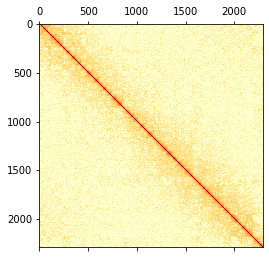

In [22]:
# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.100kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat= c.matrix(balance=True).fetch('chr2')
print(mat.shape)
idxy = ~np.all(np.isnan(mat),axis=0)
M = mat[idxy,:]
Mh = M[:,idxy]
plt.matshow(np.log1p(Mh), cmap='YlOrRd')

In [23]:
hic_hr = []
for i in range(len(Mh)-511):
    hic_hr.append(Mh[i:i+512, i:i+512])
hic_hr = np.array(hic_hr)
hic_hr_ds = tf.data.Dataset.from_tensor_slices(hic_hr)
print(hic_hr.shape)
print(hic_hr_ds.element_spec)

(1781, 512, 512)
TensorSpec(shape=(512, 512), dtype=tf.float64, name=None)


(573, 573)


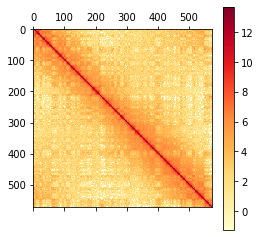

In [24]:
IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/4),int(Mh.shape[1]/4)
img_l = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH))
for i in list(range(0, len(Mh))):
    x = int(np.floor(i/(len(Mh)/IMG_HEIGHT)))
    for j in list(range(0,len(Mh))):
        y = int(np.floor(j/(len(Mh)/IMG_WIDTH)))
        img_l[x, y] = img_l[x, y] + Mh[i,j]

Ml = img_l
plt.matshow(np.log2(Ml), cmap='YlOrRd')
plt.colorbar()
print(Ml.shape)

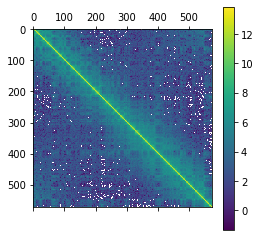

In [25]:
import copy
Ml = img_l.copy()
Ml = normalization.ICE_normalization(Ml)
#Ml = normalization.SCN_normalization(Ml)
plt.matshow(np.log2(Ml))
plt.colorbar()

In [26]:
hic_lr = []
IMG_HEIGHT, IMG_WIDTH = int(512/4),int(512/4)
print(IMG_HEIGHT, IMG_WIDTH)
for i in range(len(Ml)-IMG_HEIGHT+1):
    hic_lr.append(Ml[i:i+IMG_HEIGHT, i:i+IMG_WIDTH])
hic_lr = np.array(hic_lr)
hic_lr_ds = tf.data.Dataset.from_tensor_slices(hic_lr)
print(hic_lr.shape)
print(hic_lr_ds.element_spec)

128 128
(446, 128, 128)
TensorSpec(shape=(128, 128), dtype=tf.float64, name=None)


In [27]:
hic_lr = hic_lr[..., np.newaxis]
hic_hr = hic_hr[..., np.newaxis]
print(hic_lr.shape)
print(hic_hr.shape)

(446, 128, 128, 1)
(1781, 512, 512, 1)


In [28]:
A = tf.ones(shape=[1,128,1,64])
B = tf.ones(shape=[4,128,128,1])
WT = tf.transpose(A, perm=(0,3,2,1))
print(WT.shape)
Up = tf.tensordot(WT, B, [[3], [1]])
print(Up.shape)
Up = tf.squeeze(tf.transpose(Up, perm=[3,1,0,4,5,2]), axis=[-1,-2])
print(Up.shape)
WTW = tf.squeeze(tf.tensordot(WT, A, [[3], [1]]), axis=[2,3])
print(WTW.shape)
Down = tf.squeeze(tf.tensordot(WTW, WT, [[3], [1]]), axis=[2,3])
print(Down.shape)
#Down = tf.transpose(Down, perm=[0,1,3,2])
print(Down.shape)
H = tf.math.multiply_no_nan(WT, tf.math.divide_no_nan(Up, Down))
H = tf.nn.relu(H)
H = tf.transpose(H, perm=[0,3,2,1])
print(H.shape)

(1, 64, 1, 128)
(1, 64, 1, 4, 128, 1)
(4, 64, 1, 128)
(1, 64, 1, 64)
(1, 64, 1, 128)
(1, 64, 1, 128)
(4, 128, 1, 64)


In [85]:
class BinaryDecomposeLayer(tf.keras.layers.Layer):
    def __init__(self, filters, name='BiL'):
        super(BinaryDecomposeLayer, self).__init__(name=name)
        self.num_outputs = filters

    def build(self, input_shape):
        w_init = tf.random_normal_initializer(mean=0, stddev=3.0)
        self.w = tf.Variable( 
            initial_value = w_init(shape=(input_shape[1], self.num_outputs), dtype=tf.float32),
            trainable=True) 
        
    def call(self, input): 
        #self.w.assign(tf.clip_by_value(self.w, -5.0, 5.0))
        self.w.assign(tf.math.tanh(self.w*10))
        H = tf.tensordot(input, self.w, [[1], [0]])
        H = tf.sigmoid(H)
        '''WT = tf.transpose(self.w, perm=(0,3,2,1))
        Up = tf.tensordot(WT, input, [[3], [1]])
        Up = tf.squeeze(tf.transpose(Up, perm=[3,1,0,4,5,2]), axis=[-1,-2])
        WTW = tf.squeeze(tf.tensordot(WT, self.w, [[3], [1]]), axis=[2,3])
        Down = tf.squeeze(tf.tensordot(WTW, WT, [[3], [1]]), axis=[2,3])
        #Down = tf.transpose(Down, perm=[0,1,3,2])
        H = tf.math.multiply_no_nan(WT, tf.math.divide_no_nan(Up, Down))
        H = tf.nn.relu(H)
        H = tf.transpose(H, perm=[0,3,2,1])'''
        return H

class Rank1Reconstruct(tf.keras.layers.Layer):
    def __init__(self, filters, name='RR'):
        super(Rank1Reconstruct, self).__init__(name=name)
        self.num_outputs = filters

    def build(self, input_shape):
        pass
        
    def call(self, input):
        v = input
        vt = tf.transpose(v, perm=[0,2,1,3])
        rank1m = tf.multiply(v, vt)
        return rank1m

'''class AssembleLayer(tf.keras.layers.Layer):
    def __init__(self, filters, name='AL'):
        super(AssembleLayer, self).__init__(name=name)
        self.num_outputs = filters

    def build(self, input_shape):
        w_init = tf.random_uniform_initializer(minval=0, maxval=1)
        self.w = tf.Variable( 
            initial_value = w_init(shape=(input_shape[-1], self.num_outputs), dtype=tf.float32),
            trainable=True)

    def call(self, input):
        self.w.assign(tf.nn.relu(self.w))
        self.w.assign(tf.clip_by_value(self.w, 0, 1))
        assemble = tf.tensordot(tf.cast(input, self.w.dtype), self.w, [[-1],[0]])
        assemble = tf.nn.relu(assemble)
        assemble = tf.clip_by_value(assemble, 0, 1)
        return tf.cast(assemble, tf.float32)'''



"class AssembleLayer(tf.keras.layers.Layer):\n    def __init__(self, filters, name='AL'):\n        super(AssembleLayer, self).__init__(name=name)\n        self.num_outputs = filters\n\n    def build(self, input_shape):\n        w_init = tf.random_uniform_initializer(minval=0, maxval=1)\n        self.w = tf.Variable( \n            initial_value = w_init(shape=(input_shape[-1], self.num_outputs), dtype=tf.float32),\n            trainable=True)\n\n    def call(self, input):\n        self.w.assign(tf.nn.relu(self.w))\n        self.w.assign(tf.clip_by_value(self.w, 0, 1))\n        assemble = tf.tensordot(tf.cast(input, self.w.dtype), self.w, [[-1],[0]])\n        assemble = tf.nn.relu(assemble)\n        assemble = tf.clip_by_value(assemble, 0, 1)\n        return tf.cast(assemble, tf.float32)"

In [86]:
def basic_loss_function(y_true, y_pred):
    return tf.add(
        tf.math.reduce_std(
            tf.math.divide_no_nan(tf.subtract(y_true, y_pred), y_true), 
            axis=[1,2,3]), 
        tf.math.reduce_mean(
            tf.math.divide_no_nan(tf.abs(tf.subtract(y_true, y_pred)), y_true), 
            axis=[1,2,3])
        )
'''def basic_loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))'''

'def basic_loss_function(y_true, y_pred):\n    return tf.reduce_mean(tf.square(y_true - y_pred))'

In [87]:
def make_generator_model():
    In = tf.keras.layers.Input(shape=(128, 128, 1), name='In')
    Binary = BinaryDecomposeLayer(512, name='Bin')(In)
    #Dec1 = tf.keras.layers.Conv2D(512, [1, 128], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1.0, maxval=1.0 ),  name='Dec1')(In)
    Rec = Rank1Reconstruct(512, name='Rec1')(Binary)
    #AL = AssembleLayer(512, name='AL')(Rec)
    '''C1 = tf.keras.layers.Conv2D(128, [1,1], use_bias=False,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1000.0), 
    kernel_constraint=tf.keras.constraints.NonNeg(), name='ClusterLvl1')(AL)
    C2 = tf.keras.layers.Conv2D(16, [1,1], use_bias=False, 
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1000.0), 
    kernel_constraint=tf.keras.constraints.NonNeg(), name='ClusterLvl2')(C1)'''
    Out = tf.keras.layers.Conv2D(1, [1,1], use_bias=False, 
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=1.0, maxval=10.0), 
    kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum1')(Rec)

    model = tf.keras.models.Model(inputs=[In],outputs=[Out])
    model.compile(optimizer='adam',
              loss=basic_loss_function,
              metrics=['mae'])
    tf.keras.utils.plot_model(model, to_file='G.png', show_shapes=True)
    return model

In [88]:
model = make_generator_model()
print(model.summary())

Model: "model_451"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
In (InputLayer)              [(None, 128, 128, 1)]     0         
_________________________________________________________________
Bin (BinaryDecomposeLayer)   (None, 128, 1, 512)       65536     
_________________________________________________________________
Rec1 (Rank1Reconstruct)      (None, 128, 128, 512)     0         
_________________________________________________________________
Sum1 (Conv2D)                (None, 128, 128, 1)       512       
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
import datetime
from tensorflow.keras.models import Model

class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, data):
        super(MyCustomCallback, self).__init__()
        self.data = data
        #print(data.shape)
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            pass
            fig = plt.figure(figsize=(30, 30))            
            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Bin').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            plt.subplot(2,2,1)
            #plt.title('Dec1-H')
            plt.subplot(2,2,1)
            plt.imshow(np.squeeze(intermediate_output))
            plt.colorbar()
            m = np.squeeze(self.model.get_layer('Bin').get_weights())
            plt.subplot(2,2,2)
            #plt.title('Dec1-Weights')
            plt.subplot(2,2,2)
            plt.imshow(m)
            plt.colorbar()

            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Sum1').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            plt.subplot(2,2,3)
            #plt.title('Xhat')
            plt.subplot(2,2,3)
            plt.imshow(np.squeeze(intermediate_output))
            plt.colorbar()
            plt.subplot(2,2,4)
            #plt.title('Xhatlog2')
            plt.subplot(2,2,4)
            plt.imshow(np.log2(np.squeeze(intermediate_output)))
            plt.colorbar()
            plt.tight_layout()
            plt.savefig('./lvl1/image_at_epoch_{:04d}.png'.format(epoch))
            plt.close(fig)

            #print(intermediate_output.shape)
            '''fig = plt.figure(figsize=(30, 30))
            
            intermediate_layer_model = Model(inputs=self.model.input, outputs=self.model.get_layer('Rec1').output )
            intermediate_output = intermediate_layer_model.predict(self.data)
            #print(intermediate_output.shape)
            for i in range(0, intermediate_output.shape[3]):
                plt.subplot(8, 8, int(1+i))
                plt.imshow(np.squeeze(intermediate_output[0, :, :, i]), cmap='YlOrRd')
                plt.axis('off')
                plt.colorbar()
                plt.tight_layout()
            plt.savefig('./lvl2/image_at_epoch_{:04d}.png'.format(epoch))
            plt.close(fig)'''

In [90]:
train_data = hic_lr[::30, :,:]
print(train_data.shape)
test_data = hic_lr[1::2, :,:]

(15, 128, 128, 1)


(128, 128, 1)


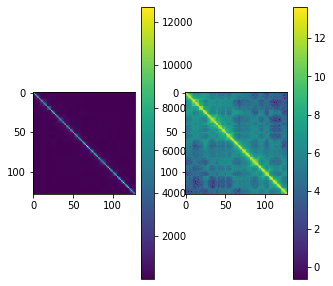

In [91]:
print(train_data[0,:,:,:].shape)
fig = plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(train_data[0,:,:,:]))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.log2(np.squeeze(train_data[0,:,:,:])))
plt.colorbar()

In [92]:
demo1 = np.ones(shape=[1,128,128,1])
demo1[0,:,:,:] = train_data[0,:,:,:]
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(demo1[0,:,:,:]))
plt.subplot(1, 2, 2)
plt.imshow(np.log1p(np.squeeze(demo1[0,:,:,:])))

_ = model.fit(train_data, train_data, epochs=800,           batch_size=3,
          callbacks=[MyCustomCallback(demo1)])
score = model.evaluate(test_data, test_data, batch_size=16)

mae: 693.4615
Epoch 92/800
15/15 [==============================] - 1s 68ms/sample - loss: 51.7041 - mae: 692.8760
Epoch 93/800
15/15 [==============================] - 1s 69ms/sample - loss: 51.6548 - mae: 692.2859
Epoch 94/800
15/15 [==============================] - 1s 67ms/sample - loss: 51.6007 - mae: 691.6995
Epoch 95/800
15/15 [==============================] - 1s 68ms/sample - loss: 51.5529 - mae: 691.1121
Epoch 96/800
15/15 [==============================] - 1s 67ms/sample - loss: 51.5006 - mae: 690.5201
Epoch 97/800
15/15 [==============================] - 1s 69ms/sample - loss: 51.4484 - mae: 689.9344
Epoch 98/800
15/15 [==============================] - 1s 69ms/sample - loss: 51.4001 - mae: 689.3461
Epoch 99/800
15/15 [==============================] - 1s 67ms/sample - loss: 51.3484 - mae: 688.7516
Epoch 100/800
15/15 [==============================] - 1s 69ms/sample - loss: 51.2963 - mae: 688.1646
Epoch 101/800
15/15 [==============================] - 2s 145ms/sample - los

KeyboardInterrupt: 

5183925.776807791
5913300.0
3523622.679764811


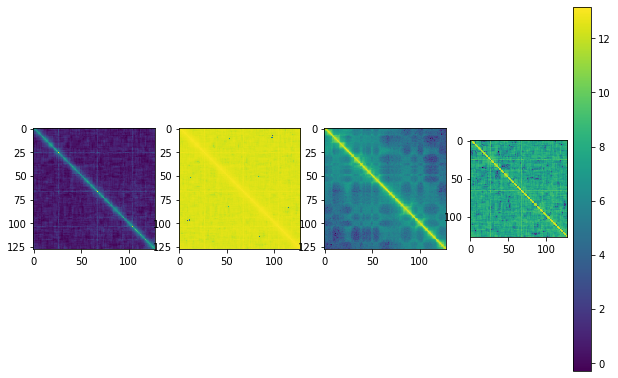

In [63]:
demo1[0,:,:,:] = test_data[0,:,:,:]
pre = model.predict(demo1)
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(np.squeeze(pre[0,:,:,:]))
plt.subplot(1, 4, 2)
plt.imshow(np.log2(np.squeeze(pre[0,:,:,:])))
plt.subplot(1, 4, 3)
plt.imshow(np.log2(np.squeeze(demo1)))
plt.subplot(1, 4, 4)
plt.imshow(np.log2(np.squeeze(np.abs(pre-demo1))))
plt.colorbar()
print(np.abs(pre-demo1).sum())
print(pre.sum())
print(demo1.sum())